In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data 

In [3]:
# generate data for grid network (features and costs)
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
x, c = spo.data.shortestpath.genData(n+1000, p, grid, deg=deg)

## Optimization Model 

In [4]:
# model for shortest path
sp_model = spo.model.grb.shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-10-08
Using license file C:\Users\Apocrypse\gurobi.lic


In [5]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [7]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [8]:
# get training data set
sp_dataset_train = spo.data.dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 481.62it/s]


In [9]:
# get test data set
sp_dataset_test = spo.data.dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 490.96it/s]


In [10]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [11]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [12]:
x.shape

torch.Size([32, 5])

In [13]:
c.shape

torch.Size([32, 40])

In [14]:
w.shape

torch.Size([32, 40])

In [15]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Learn 

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
# prediction model
reg = LinearRegression()

## Two-Stage

In [18]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, sp_model)

In [19]:
# training
twostage_model.fit(sp_dataset_train.x, sp_dataset_train.c)

In [20]:
# prediction
c_test_pred = twostage_model.predict(sp_dataset_test.x)

In [21]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = sp_dataset_test.c[i]
    z_true_i = sp_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(sp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(sp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(sp_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(sp_dataset_test.z.sum()) * 100))

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.86it/s]


Normalized true SPO Loss: 1.61%
Normalized unambiguous SPO Loss: 1.61%


In [22]:
# compare solutions
for i, data in enumerate(sp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.28, 0.16, 0.55, -0.67, 0.99, -0.21, -0.41, 0.30, -0.19, 0.41, -0.21, 0.04, -0.57, 0.30, -0.33, 0.30, -0.84, 0.20, 0.05, -0.21, 0.04, 0.20, 0.57, -0.09, 0.79, -0.41, -0.33, -0.33, 0.46, 0.55, 0.33, -0.57, 0.33, 0.16, 0.55, 0.55, -0.41, 0.55, -0.05, 0.20
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.47

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.10

## Linear Regression from PyTorch

In [23]:
from torch import nn

In [24]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+

In [25]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [26]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [27]:
# init SPO+ loss
criterion = spo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [28]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   3.7523, True SPO Loss: 25.3060%, Unambiguous SPO Loss: 25.3060%
Epoch  20, Loss:   1.8804, True SPO Loss: 11.6377%, Unambiguous SPO Loss: 11.6377%
Epoch  30, Loss:   1.3852, True SPO Loss:  4.7241%, Unambiguous SPO Loss:  4.7241%
Epoch  40, Loss:   0.3101, True SPO Loss:  1.9643%, Unambiguous SPO Loss:  1.9643%
Epoch  50, Loss:   0.8810, True SPO Loss:  1.2629%, Unambiguous SPO Loss:  1.2629%
Epoch  60, Loss:   0.4747, True SPO Loss:  0.9158%, Unambiguous SPO Loss:  0.9158%
Epoch  70, Loss:   0.1265, True SPO Loss:  0.6890%, Unambiguous SPO Loss:  0.6890%
Epoch  80, Loss:   0.1844, True SPO Loss:  0.5940%, Unambiguous SPO Loss:  0.5940%
Epoch  90, Loss:   0.7967, True SPO Loss:  0.5207%, Unambiguous SPO Loss:  0.5207%
Epoch 100, Loss:   0.0000, True SPO Loss:  0.5692%, Unambiguous SPO Loss:  0.5692%
Epoch 110, Loss:   0.0594, True SPO Loss:  0.5148%, Unambiguous SPO Loss:  0.5148%
Epoch 120, Loss:   0.0185, True SPO Loss:  0.5734%, Unambiguous SPO Loss:  0.5734%
Epoc

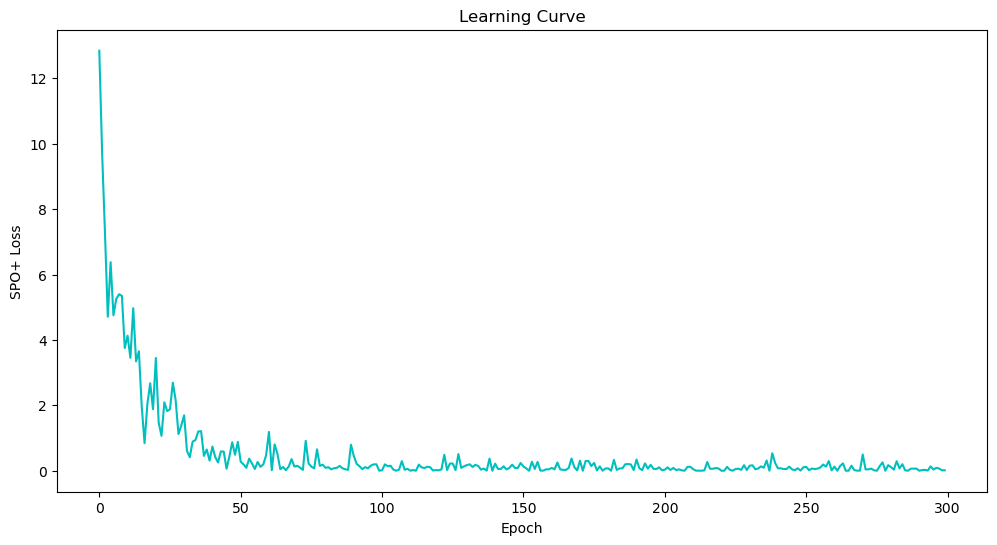

In [29]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

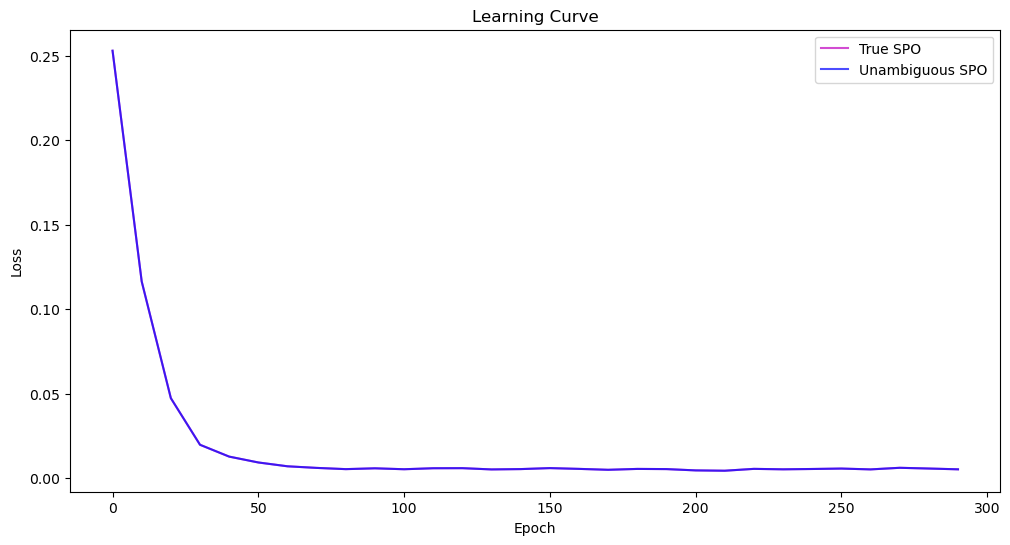

In [30]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [31]:
# evaluate
spoloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.51%
Normalized unambiguous SPO Loss: 0.51%


In [32]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -0.46, 0.69, 0.65, -1.25, 1.95, -0.08, -0.41, 0.07, 0.78, 0.33, -0.28, -0.42, -0.35, 0.28, -0.01, 0.96, -1.25, -0.48, 0.52, -0.46, -0.73, 0.06, 0.69, 0.67, -0.04, -0.41, -0.31, -0.31, -0.59, 0.96, -0.03, 0.50, -0.28, -0.56, 0.50, 0.82, -1.64, -0.34, 0.10, 0.43
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.38

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17

##  SPO+ with Regularization

In [33]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [34]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [35]:
# init SPO+ loss
criterion = spo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [36]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   4.9223, True SPO Loss: 36.7885%, Unambiguous SPO Loss: 36.7885%
Epoch  20, Loss:   2.3936, True SPO Loss: 17.2362%, Unambiguous SPO Loss: 17.2362%
Epoch  30, Loss:   1.2374, True SPO Loss:  5.8255%, Unambiguous SPO Loss:  5.8255%
Epoch  40, Loss:   0.1236, True SPO Loss:  2.2611%, Unambiguous SPO Loss:  2.2611%
Epoch  50, Loss:   0.1492, True SPO Loss:  1.2438%, Unambiguous SPO Loss:  1.2438%
Epoch  60, Loss:   0.1072, True SPO Loss:  0.8239%, Unambiguous SPO Loss:  0.8239%
Epoch  70, Loss:   0.3812, True SPO Loss:  0.7282%, Unambiguous SPO Loss:  0.7282%
Epoch  80, Loss:   0.0976, True SPO Loss:  0.6992%, Unambiguous SPO Loss:  0.6992%
Epoch  90, Loss:   0.1060, True SPO Loss:  0.6525%, Unambiguous SPO Loss:  0.6525%
Epoch 100, Loss:   0.2296, True SPO Loss:  0.5257%, Unambiguous SPO Loss:  0.5257%
Epoch 110, Loss:   0.0431, True SPO Loss:  0.5671%, Unambiguous SPO Loss:  0.5671%
Epoch 120, Loss:   0.0424, True SPO Loss:  0.5251%, Unambiguous SPO Loss:  0.5251%
Epoc

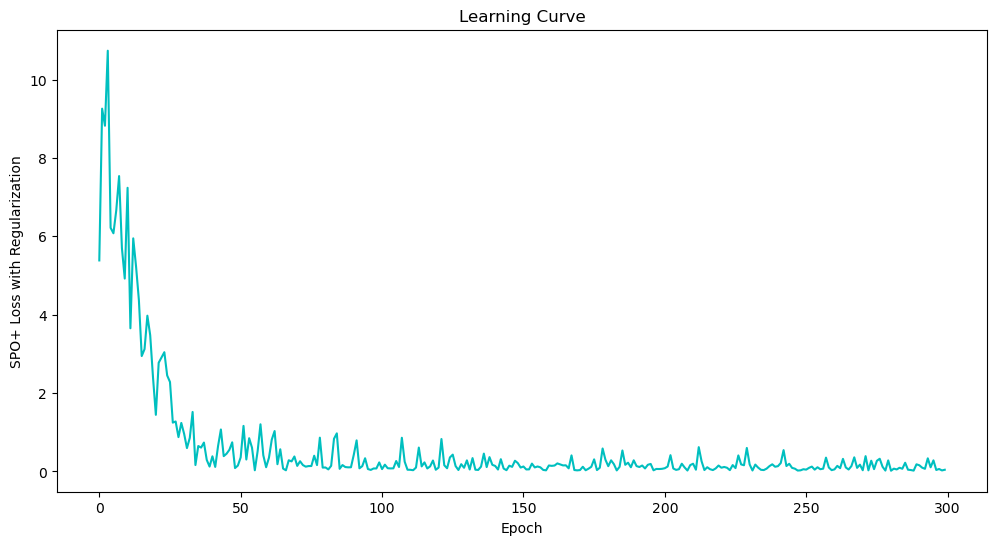

In [37]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss with Regularization')
plt.title('Learning Curve')
plt.show()

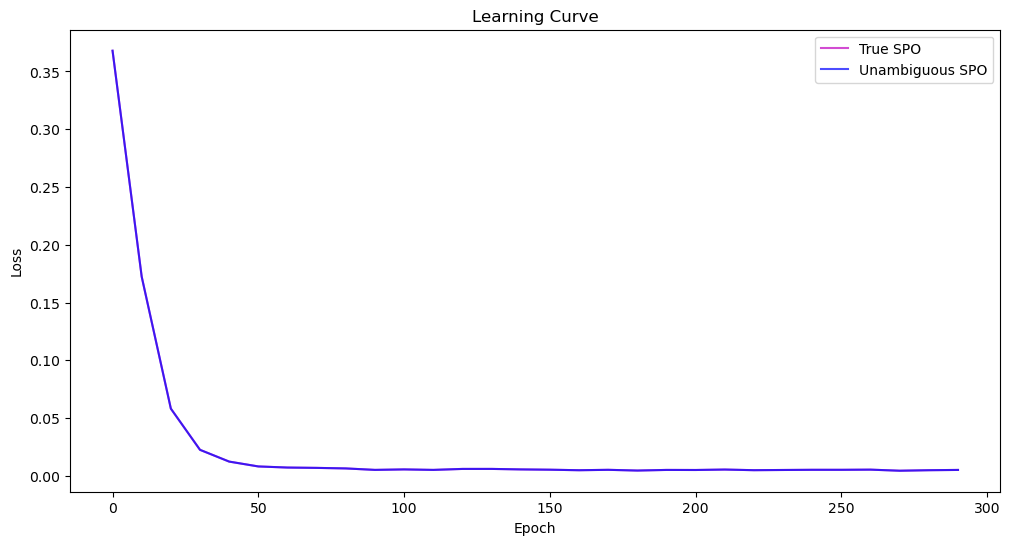

In [38]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [39]:
# evaluate
spoloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.52%
Normalized unambiguous SPO Loss: 0.52%


In [40]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -0.67, 0.10, 0.69, -0.27, 0.87, -0.42, 0.19, 0.22, 0.19, 0.53, 0.09, 0.20, -0.68, 0.48, 0.41, 0.86, -0.64, 0.56, 0.45, -0.20, 0.25, -0.15, 0.66, 0.43, 0.45, -0.73, -0.84, -0.35, 0.42, 1.14, -0.28, -0.39, 0.53, 0.32, 0.25, 1.07, -0.15, 0.60, -0.81, 0.61
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.38

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.10, 

## Black-Box

In [41]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [42]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-4)

In [43]:
# set loss
criterion = nn.L1Loss()
bb = spo.func.blackboxOpt(sp_model, lambd=10, processes=4)

Num of cores: 4


In [44]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   1.7388, True SPO Loss: 40.9203%, Unambiguous SPO Loss: 40.9203%
Epoch  20, Loss:   0.8275, True SPO Loss: 27.4203%, Unambiguous SPO Loss: 27.4203%
Epoch  30, Loss:   0.5871, True SPO Loss: 19.3379%, Unambiguous SPO Loss: 19.3379%
Epoch  40, Loss:   0.5028, True SPO Loss: 13.8261%, Unambiguous SPO Loss: 13.8261%
Epoch  50, Loss:   0.6928, True SPO Loss: 10.0225%, Unambiguous SPO Loss: 10.0225%
Epoch  60, Loss:   2.4093, True SPO Loss:  7.5354%, Unambiguous SPO Loss:  7.5354%
Epoch  70, Loss:   0.0919, True SPO Loss:  5.7407%, Unambiguous SPO Loss:  5.7407%
Epoch  80, Loss:   1.2066, True SPO Loss:  6.3479%, Unambiguous SPO Loss:  6.3479%
Epoch  90, Loss:   0.3544, True SPO Loss:  6.0619%, Unambiguous SPO Loss:  6.0619%
Epoch 100, Loss:   0.0102, True SPO Loss:  5.6200%, Unambiguous SPO Loss:  5.6200%
Epoch 110, Loss:   0.3841, True SPO Loss:  8.1098%, Unambiguous SPO Loss:  8.1098%
Epoch 120, Loss:   0.1779, True SPO Loss:  4.2137%, Unambiguous SPO Loss:  4.2137%
Epoc

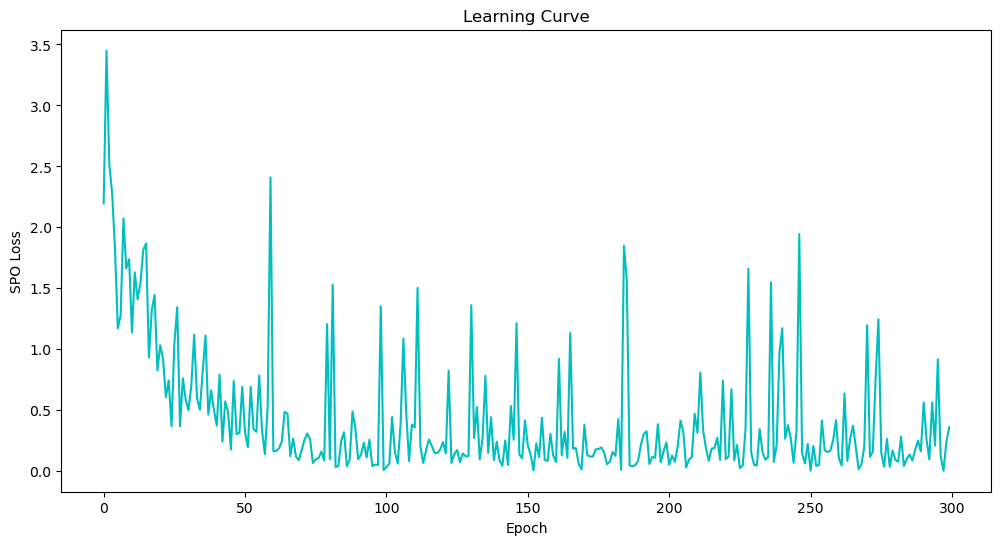

In [45]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

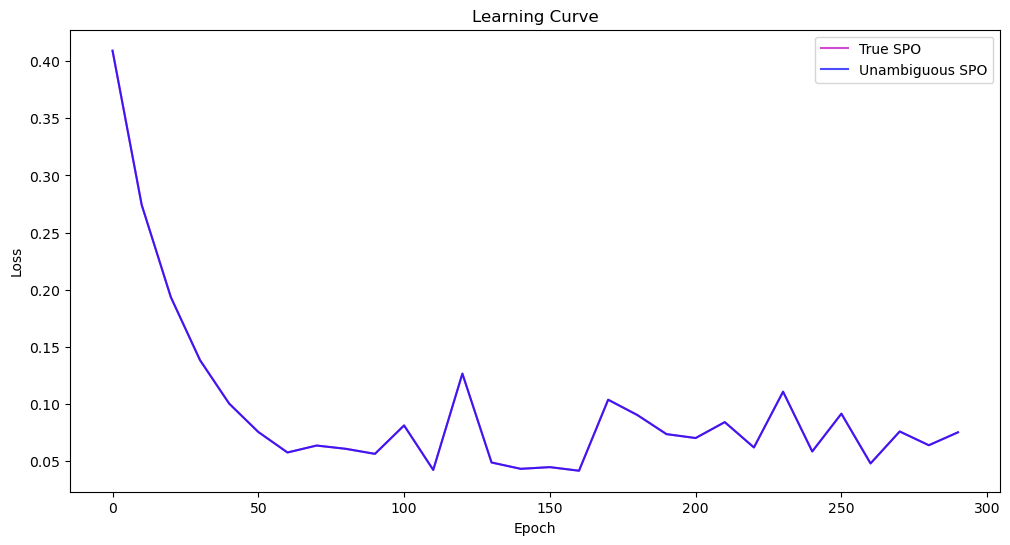

In [46]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [47]:
# evaluate
spoloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 7.51%
Normalized unambiguous SPO Loss: 7.51%


In [48]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.97, 0.39, -0.17, -1.83, 0.21, -0.34, -0.44, -0.50, -1.59, 0.71, -1.31, 0.41, -0.57, -0.69, -1.16, 0.71, 0.12, 1.18, 0.37, 0.22, 0.02, -0.16, 0.23, 0.64, 0.53, -1.42, 0.38, 0.76, 0.26, -0.94, 0.67, 1.06, -0.08, -0.49, 1.38, 0.14, -0.31, 0.50, 0.07, -0.63
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.52

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.1

## Black-Box with Regularization

In [49]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [50]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-4)

In [51]:
# set loss
bb = spo.func.blackboxOpt(sp_model, lambd=10, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [52]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   1.6897, True SPO Loss: 23.3559%, Unambiguous SPO Loss: 23.3559%
Epoch  20, Loss:   1.2557, True SPO Loss: 16.0703%, Unambiguous SPO Loss: 16.0703%
Epoch  30, Loss:   0.7347, True SPO Loss: 13.3763%, Unambiguous SPO Loss: 13.3763%
Epoch  40, Loss:   0.8792, True SPO Loss: 11.4588%, Unambiguous SPO Loss: 11.4588%
Epoch  50, Loss:   0.3106, True SPO Loss:  9.2945%, Unambiguous SPO Loss:  9.2945%
Epoch  60, Loss:   1.4061, True SPO Loss:  8.1974%, Unambiguous SPO Loss:  8.1974%
Epoch  70, Loss:   0.2138, True SPO Loss:  7.6392%, Unambiguous SPO Loss:  7.6392%
Epoch  80, Loss:   0.1341, True SPO Loss:  6.8049%, Unambiguous SPO Loss:  6.8049%
Epoch  90, Loss:   0.3029, True SPO Loss:  6.9745%, Unambiguous SPO Loss:  6.9745%
Epoch 100, Loss:   0.0649, True SPO Loss:  7.8186%, Unambiguous SPO Loss:  7.8186%
Epoch 110, Loss:   0.2207, True SPO Loss:  6.2924%, Unambiguous SPO Loss:  6.2924%
Epoch 120, Loss:   0.1606, True SPO Loss:  8.2506%, Unambiguous SPO Loss:  8.2506%
Epoc

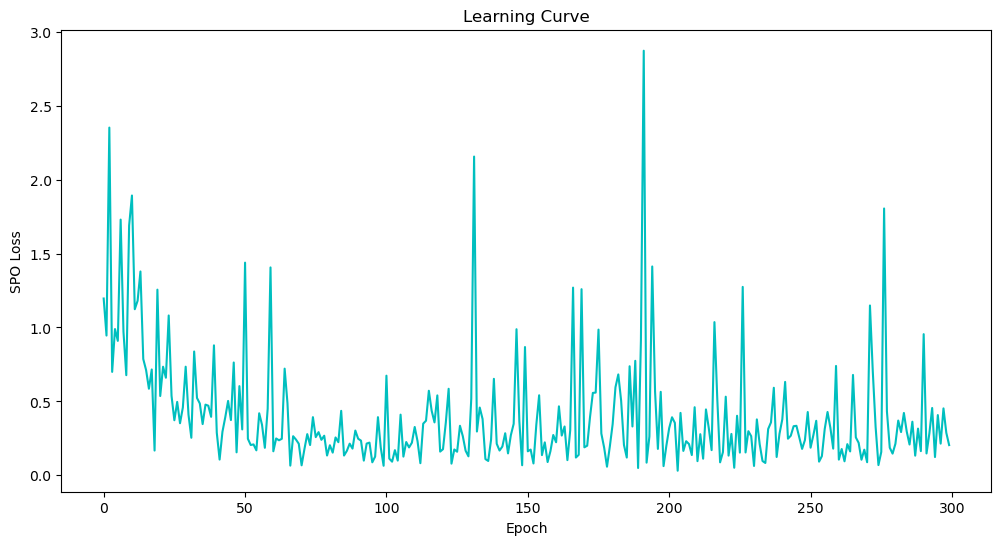

In [53]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

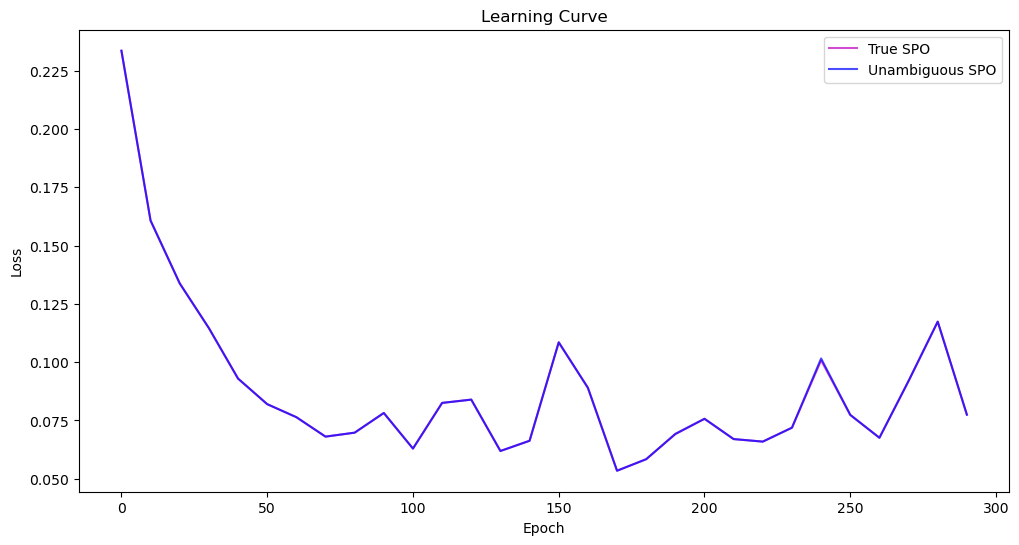

In [54]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [55]:
# evaluate
spoloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 7.75%
Normalized unambiguous SPO Loss: 7.75%


In [56]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.03, 1.08, -0.72, -1.90, -0.95, -0.65, -0.28, 0.13, 0.37, 0.34, -0.13, 0.40, 1.07, 0.64, 0.41, 0.58, 0.06, -0.73, 0.11, 0.03, -1.55, -0.03, 1.09, 0.51, 0.34, 0.72, 1.15, 0.36, -0.14, 0.46, 0.64, -0.84, 0.38, -0.70, 0.17, -1.21, 0.44, -0.20, -0.22, -1.11
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.52

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.10